## Criterio de Analisis de Pareto

El Análisis ABC (Pareto) es fundamental para la gestión hospitalaria. Nos permitirá separar lo "trivial" de lo "vital".
* 
Clase A (Vital): Representan el 80% del gasto. Suelen ser pocos ítems (ej: oncológicos, prótesis, antibióticos caros). Requieren control de stock diario y predicción con IA.
* 
Clase B (Importante): Representan el siguiente 15%. Gestión mensual
* .
Clase C (Trivial): Representan el último 5% del dinero, pero suelen ser la mayoría de los ítems (ej: gasas, jeringas baratas). Se pueden pedir en lote y stockear sin riesgo financiero.

🚀 Iniciando Análisis ABC + Reporte Evolutivo (Interactivo)...
✅ Datos listos y clasificados por Rubro.
💾 Tabla 'analytics_abc_pareto' actualizada en BD.


🔵 ==========================================================
🔬 RUBRO: MEDICAMENTOS
🔵 ==========================================================
Top 10 Insumos Críticos (Clase A) - Evolución Anual:


,2019 (USD),2020 (USD),2021 (USD),2022 (USD),2023 (USD),2024 (USD),2025 (USD),TOTAL_HISTORICO
descripcion_insumo,,,,,,,,
Midazolan 15 mg ampolla x 3 ml,"$23,928","$154,383","$1,351,342","$65,678","$35,716","$17,817","$8,971","$1,657,835"
Leche entera Fortificada con V,$0,$0,$152,"$624,481","$498,883","$285,509",$0,"$1,409,024"
Solucion cloruro de sodio 0.9%,"$59,327","$71,350","$143,708","$135,574","$185,355","$94,264","$151,830","$841,408"
Ceftazidima 2 g/avibactam 0.5,"$38,817","$68,617","$56,753","$117,123","$151,000","$16,273","$280,430","$729,012"
Atracurio 50 mg/5 ml ampolla,$998,"$119,159","$485,579","$27,981","$2,410","$9,587","$10,936","$656,650"
Solucion de cloruro de sodio 0,"$18,060","$66,876","$34,047","$93,828","$108,661","$189,812","$124,381","$635,665"
Propofol 10 mg/ml ampolla x 20,"$14,004","$36,568","$324,954","$70,754","$18,126","$90,120","$56,554","$611,080"
Cartucho plastico carticaína 4,"$21,939",$0,"$47,621","$122,369","$153,554","$153,774","$75,615","$574,872"
Anfotericina B Liposomal 50 mg,"$43,250","$66,980",$0,"$105,381","$93,413","$22,261","$226,726","$558,010"


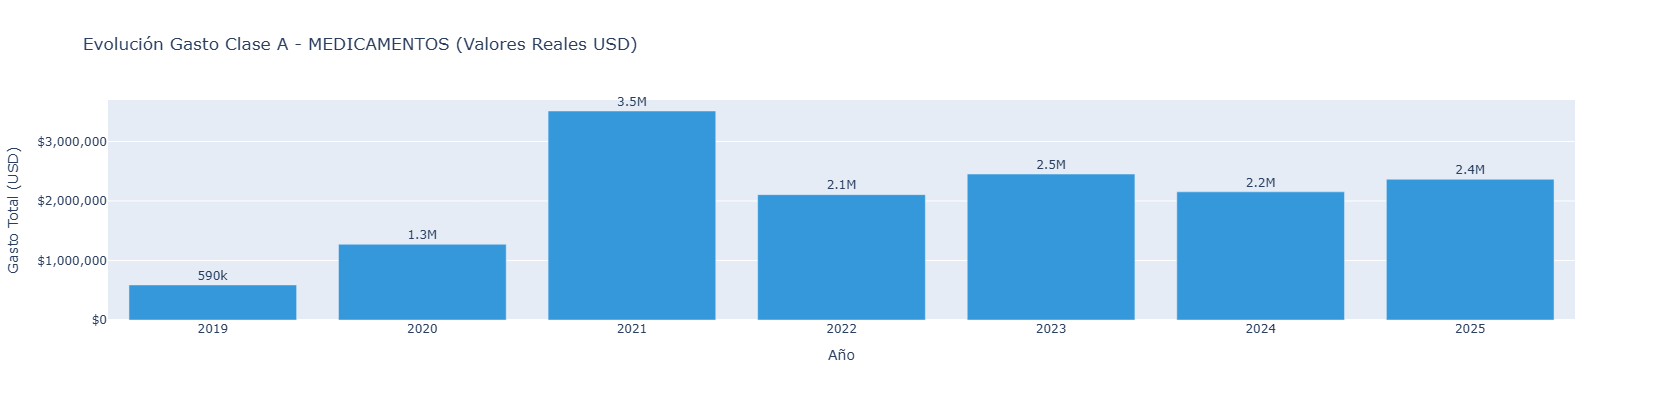



🔵 ==========================================================
🔬 RUBRO: BIOMEDICOS
🔵 ==========================================================
Top 10 Insumos Críticos (Clase A) - Evolución Anual:


,2019 (USD),2020 (USD),2021 (USD),2022 (USD),2023 (USD),2024 (USD),2025 (USD),TOTAL_HISTORICO
descripcion_insumo,,,,,,,,
Camisolin descartable manga la,"$66,864","$602,232","$1,133,835","$566,992","$240,173","$201,244","$186,835","$2,998,177"
Guante latex descart.p/examen,"$99,822","$327,974","$805,376","$383,224","$248,019","$309,431","$126,284","$2,300,130"
Leche entera Fortificada con V,"$849,049","$626,752","$425,192","$23,560",$0,$0,$0,"$1,924,552"
Prueba rápida Naso/Faringea de,$0,"$101,716","$636,319","$166,450","$24,311","$4,320","$3,790","$936,906"
Barbijo descartable de tres pl,$535,"$243,463","$136,541","$46,106","$14,641","$14,124","$9,198","$464,609"
Sonda urinaria esteril autolub,$0,$0,$0,"$35,121","$139,567","$137,804","$120,667","$433,158"
Detergente desinfectante de in,"$36,356","$68,764","$91,501","$61,976","$46,770","$35,940","$10,512","$351,818"
Pañal descartable c/gel Adulto,$0,"$30,787","$28,566","$48,517","$101,285","$38,040","$87,740","$334,934"
Brackets Roth c/Hook 022x030 x,"$23,508",$0,$0,"$56,155","$77,264","$83,006","$77,860","$317,793"


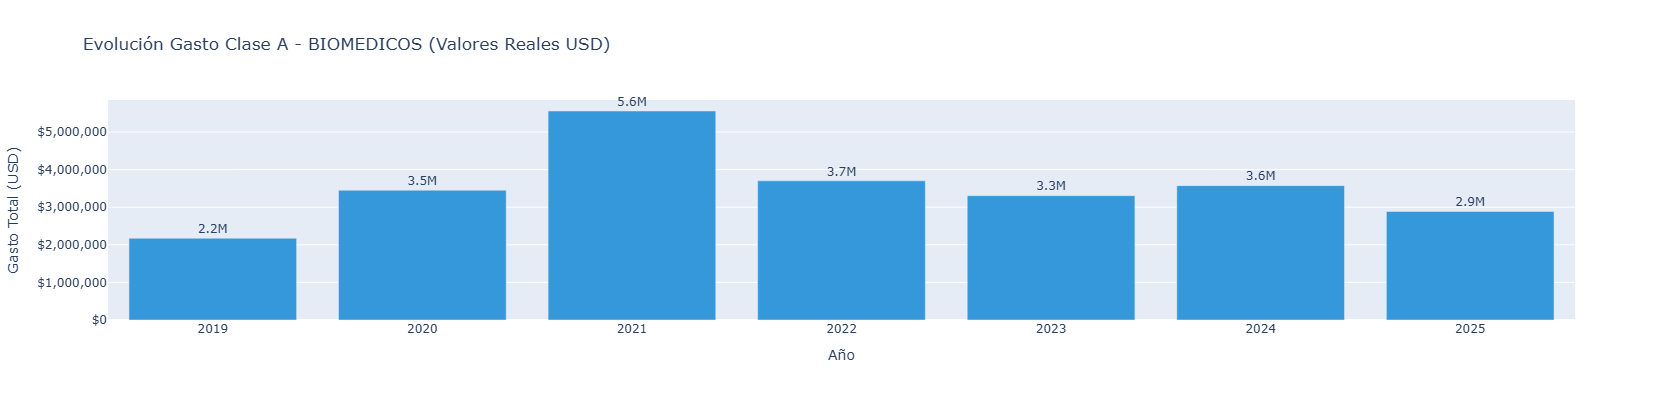



🔵 ==========================================================
🔬 RUBRO: LABORATORIO
🔵 ==========================================================
Top 10 Insumos Críticos (Clase A) - Evolución Anual:


,2019 (USD),2020 (USD),2021 (USD),2022 (USD),2023 (USD),2024 (USD),2025 (USD),TOTAL_HISTORICO
descripcion_insumo,,,,,,,,
Reactivo p/vitamina D- electro,$0,"$2,150","$42,702","$105,281","$111,884","$229,903","$218,678","$710,599"
Reactivo p/hemograma AUTOMATIZ,$0,$0,$0,$0,"$28,635","$184,280","$232,474","$445,389"
Reactivo p/TSH AUTOMATIZADO,"$1,158",$886,"$29,497","$40,626","$65,427","$78,241","$56,010","$271,843"
Reactivo p/LDH UV método AUTOM,$243,$333,"$2,988","$34,087","$162,286",$0,$0,"$199,936"
Reactivo p/hemoglobina glicosi,"$2,051","$2,638","$24,160","$31,795","$22,581","$48,834","$48,661","$180,720"
Tubo p/ hemograma c/edta 3ml c,"$6,426","$10,028","$22,091","$23,613","$27,240","$45,051","$27,413","$161,862"
Reactivo p/preanalítica AUTOMA,$0,$0,$0,$0,"$17,214","$71,121","$70,317","$158,651"
Reactivo p/colesterol HDL AUTO,"$2,263","$2,547","$12,785","$33,480","$19,864","$44,718","$34,045","$149,703"
Reactivo p/PSA total AUTOMATIZ,$0,$919,"$12,286","$21,748","$28,629","$48,679","$30,885","$143,146"


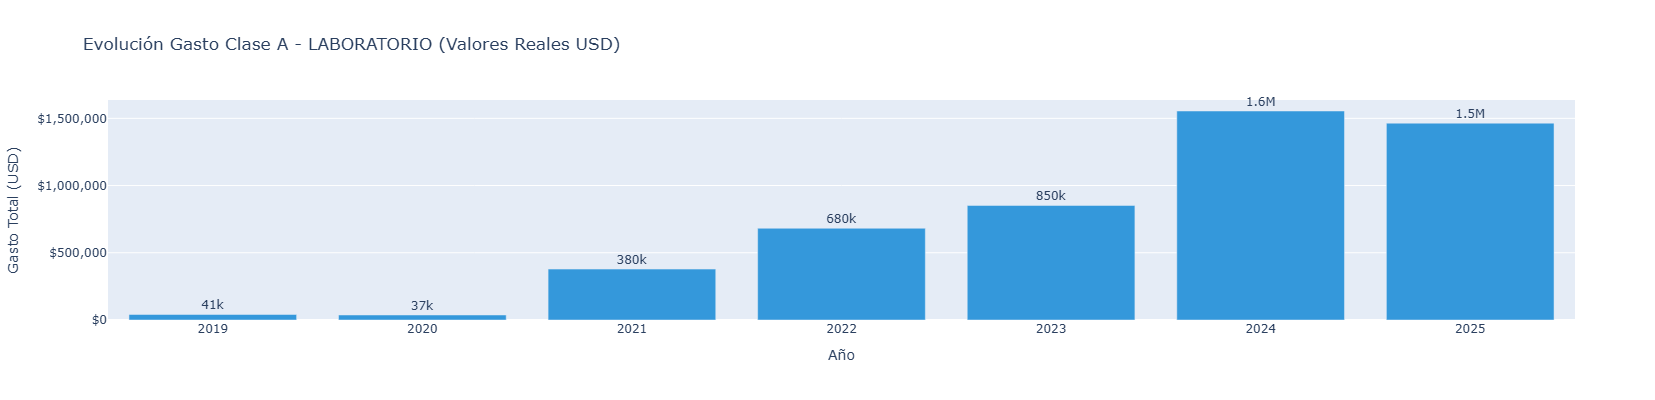



🔵 ==========================================================
🔬 RUBRO: ODONTOLOGIA
🔵 ==========================================================
Top 10 Insumos Críticos (Clase A) - Evolución Anual:


,2019 (USD),2020 (USD),2021 (USD),2022 (USD),2023 (USD),2024 (USD),2025 (USD),TOTAL_HISTORICO
descripcion_insumo,,,,,,,,
Guante latex descart.p/examen,"$10,416",$0,"$78,722","$27,444","$28,739","$31,534","$14,165","$191,020"
Camisolin descartable manga la,"$1,577",$0,"$83,080","$41,526","$13,576","$15,063","$12,937","$167,759"
Prueba rápida Naso/Faringea de,$0,$0,"$125,240",$0,$0,$0,$0,"$125,240"
Ionómero vitreo p/restaurar al,"$13,165",$0,"$1,767","$14,473","$31,676","$32,173","$15,695","$108,948"
Sillón odontológico,$0,$0,"$17,544","$10,820","$65,000",$0,$0,"$93,363"
Papel pouch c/verif.quimico p/,"$6,163",$0,"$10,989","$14,481","$24,794","$21,926","$12,661","$91,013"
Brackets Roth c/Hook 022x030 x,"$7,600",$0,$0,"$10,669","$18,687","$20,667","$21,707","$79,330"
Detergente desinfectante de in,"$9,948",$0,"$21,680","$17,815","$11,855","$12,156","$3,910","$77,365"
Cartucho carticaina 4% c/L-adr,"$5,347",$0,"$5,076","$11,377","$17,269","$7,859",$0,"$46,928"


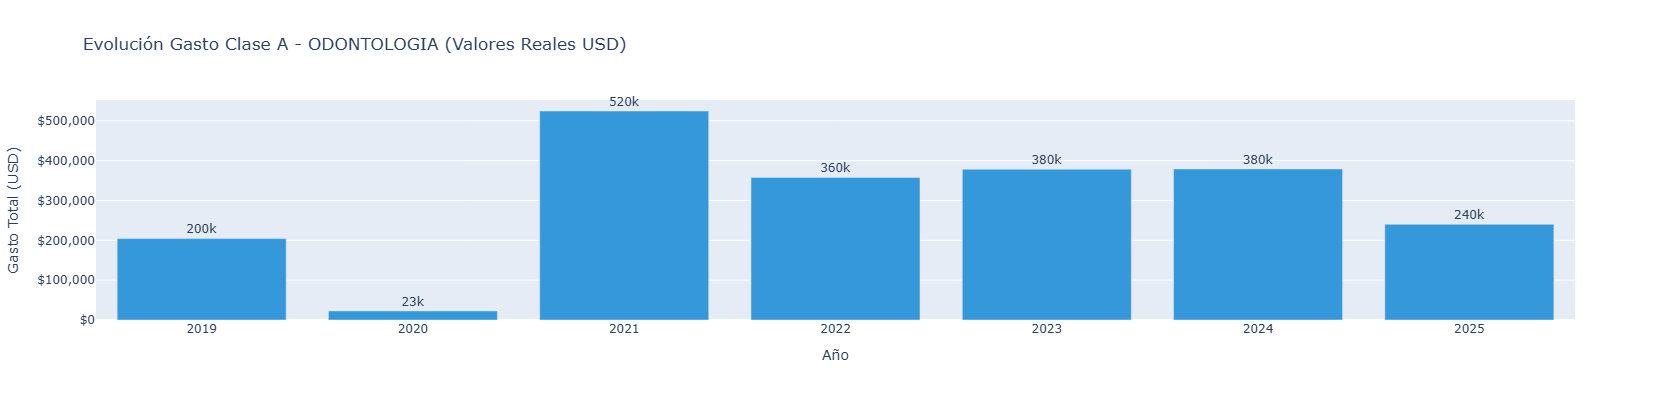

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px  # <--- NUEVA LIBRERÍA
from sqlalchemy import create_engine, text

# Configuración visual de Pandas
pd.options.display.float_format = '{:,.2f}'.format

# =============================================================================
# 1. CARGA, DOLARIZACIÓN Y CLASIFICACIÓN
# =============================================================================
print("🚀 Iniciando Análisis ABC + Reporte Evolutivo (Interactivo)...")

# Conexión
DB_USER = 'analista_medhos'
DB_PASS = 'Medhos2025!'
DB_HOST = 'postgres'
DB_NAME = 'medhos_dw'
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:5432/{DB_NAME}')

# Carga
df = pd.read_sql("SELECT * FROM raw_movimientos_siga WHERE tipo_archivo_detectado = 'SALIDA'", engine)
df_dolar = pd.read_sql("SELECT fecha, tipo_cambio_oficial_venta FROM dim_cotizaciones", engine)

# Procesamiento Fechas y Dólar
df['fecha_movimiento'] = pd.to_datetime(df['fecha_movimiento'])
df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'])
df = df.sort_values('fecha_movimiento')
df_dolar = df_dolar.sort_values('fecha')

df = pd.merge_asof(df, df_dolar, left_on='fecha_movimiento', right_on='fecha', direction='backward')
df['cotizacion_usd'] = df['tipo_cambio_oficial_venta'].ffill().bfill()
df['precio_total_usd'] = df['precio_total'] / df['cotizacion_usd']
df['anio'] = df['fecha_movimiento'].dt.year

# --- SEPARACIÓN DE LABORATORIO (HEURÍSTICA) ---
keywords_laboratorio = [
    'REACTIVO', 'TUBO P/', 'HEMOGRAMA', 'CREATININA', 'GLUCOSA', 
    'VITAMINA', 'CALIBRADOR', 'CONTROL DE CALIDAD', 'SEROLOGIA',
    'ELISA', 'PCR ', 'AGAR ', 'MEDIO DE CULTIVO', 'HEMOSTASIA',
    'BILIRRUBINA', 'UREA', 'COLESTEROL', 'HIV', 'HEPATITIS', 
    'ORINA', 'CITOLOGIA', 'HISTOLOGIA', 'BIOPSIA', 'ANTIGENO'
]

def clasificar_rubro(row):
    cod_dep = str(row['deposito_origen_cod'])
    desc = str(row['descripcion_insumo']).upper()
    if cod_dep == '2311': return 'MEDICAMENTOS'
    if cod_dep == '2015': return 'ODONTOLOGIA'
    if cod_dep == '2678' or cod_dep == '2878':
        if any(k in desc for k in keywords_laboratorio): return 'LABORATORIO'
        else: return 'BIOMEDICOS'
    return 'OTROS'

df['rubro'] = df.apply(clasificar_rubro, axis=1)

print("✅ Datos listos y clasificados por Rubro.")

# =============================================================================
# 2. CÁLCULO ABC (HISTÓRICO)
# =============================================================================
rubros = ['MEDICAMENTOS', 'BIOMEDICOS', 'LABORATORIO', 'ODONTOLOGIA']
resultados_abc = []

for rubro in rubros:
    subset = df[df['rubro'] == rubro]
    if len(subset) == 0: continue
    
    # Agrupamos por insumo (Todo el periodo)
    abc = subset.groupby(['cod_insumo', 'descripcion_insumo'])['precio_total_usd'].sum().reset_index()
    abc = abc.sort_values('precio_total_usd', ascending=False)
    
    total = abc['precio_total_usd'].sum()
    abc['acumulado'] = (abc['precio_total_usd'] / total).cumsum()
    
    # Asignar Clase
    abc['clase'] = abc['acumulado'].apply(lambda x: 'A' if x <= 0.80 else ('B' if x <= 0.95 else 'C'))
    abc['rubro'] = rubro
    resultados_abc.append(abc)

df_abc_final = pd.concat(resultados_abc)

# Guardar en BD
df_abc_final.to_sql('analytics_abc_pareto', engine, if_exists='replace', index=False)
print("💾 Tabla 'analytics_abc_pareto' actualizada en BD.")

# =============================================================================
# 3. REPORTE EVOLUTIVO POR RUBRO (CON PLOTLY)
# =============================================================================
# Unimos la info ABC con los datos originales
df_completo = df.merge(df_abc_final[['cod_insumo', 'clase']], on='cod_insumo', how='left')

for rubro in rubros:
    print(f"\n\n🔵 ==========================================================")
    print(f"🔬 RUBRO: {rubro}")
    print(f"🔵 ==========================================================")
    
    # Filtramos solo items CLASE A (Los críticos)
    data_rubro = df_completo[
        (df_completo['rubro'] == rubro) & 
        (df_completo['clase'] == 'A')
    ]
    
    if len(data_rubro) == 0:
        print("No hay datos.")
        continue

    # --- TABLA PIVOT (Igual que antes, para ver el detalle) ---
    pivot = data_rubro.pivot_table(
        index=['descripcion_insumo'], 
        columns='anio', 
        values='precio_total_usd', 
        aggfunc='sum', 
        fill_value=0
    )
    pivot['TOTAL_HISTORICO'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('TOTAL_HISTORICO', ascending=False)
    
    pivot.columns = [f"{c} (USD)" if c != 'TOTAL_HISTORICO' else c for c in pivot.columns]
    print(f"Top 10 Insumos Críticos (Clase A) - Evolución Anual:")
    display(pivot.head(10).style.format("${:,.0f}"))
    
    # --- GRÁFICO INTERACTIVO CON PLOTLY ---
    # Preparamos los datos para el gráfico
    gasto_anual = data_rubro.groupby('anio')['precio_total_usd'].sum().reset_index()
    
    fig = px.bar(
        gasto_anual, 
        x='anio', 
        y='precio_total_usd',
        title=f'Evolución Gasto Clase A - {rubro} (Valores Reales USD)',
        labels={'precio_total_usd': 'Gasto Total (USD)', 'anio': 'Año'},
        text_auto='.2s', # Formato compacto (M = Millones, k = Miles)
        color_discrete_sequence=['#3498db'] # Un color azul profesional
    )
    
    # Mejoras visuales del gráfico
    fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
    fig.update_layout(
        xaxis=dict(type='category'), # Para mostrar años como categorías (2019, 2020...)
        yaxis=dict(tickformat="$,.0f"), # Formato de eje Y en dólares
        height=400
    )
    
    fig.show()